<a href="https://colab.research.google.com/github/yasinsoylu1997/128-not-sampling/blob/main/vgg19_models_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.metrics import log_loss
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:18<00:00, 70.91it/s] 


In [5]:
train_images, test_images,train_labels, test_labels = train_test_split(X , y , test_size=0.25, random_state=42,shuffle=True)

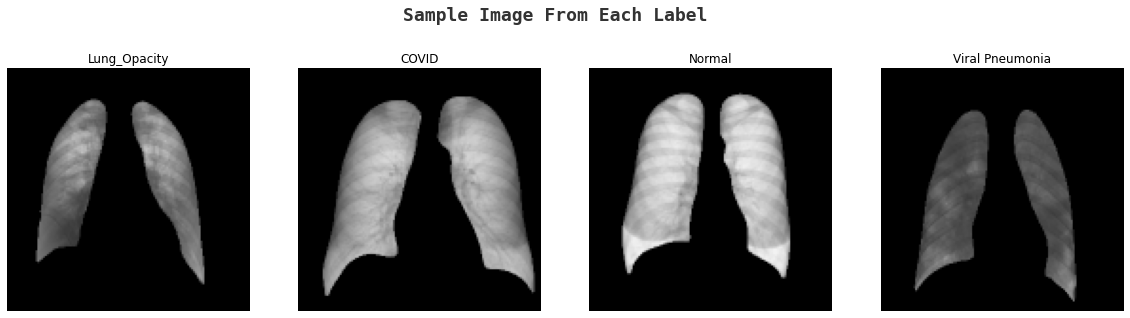

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

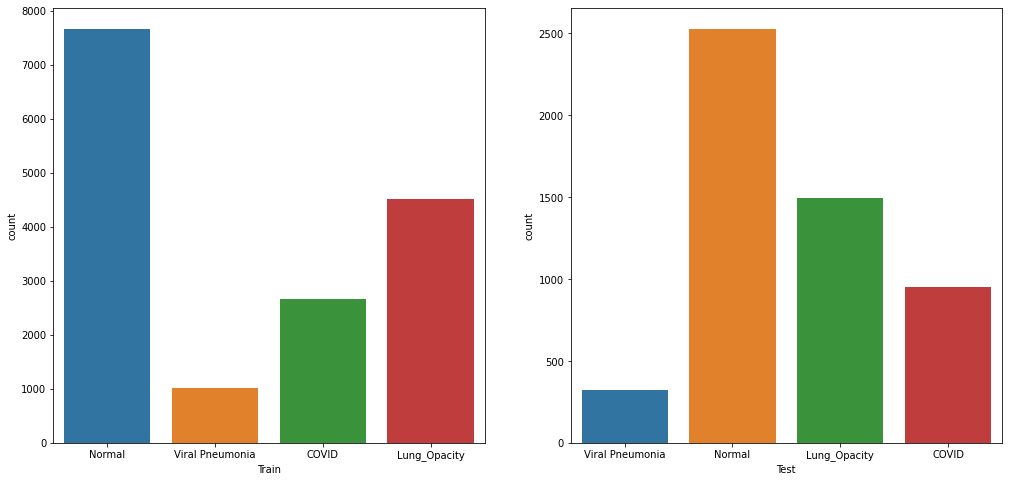

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [20]:
from tensorflow.keras.applications import MobileNet
MobilNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in MobilNet_model.layers:
	layer.trainable = False
    
MobilNet_model.summary()  #Trainable parameters will be 0

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

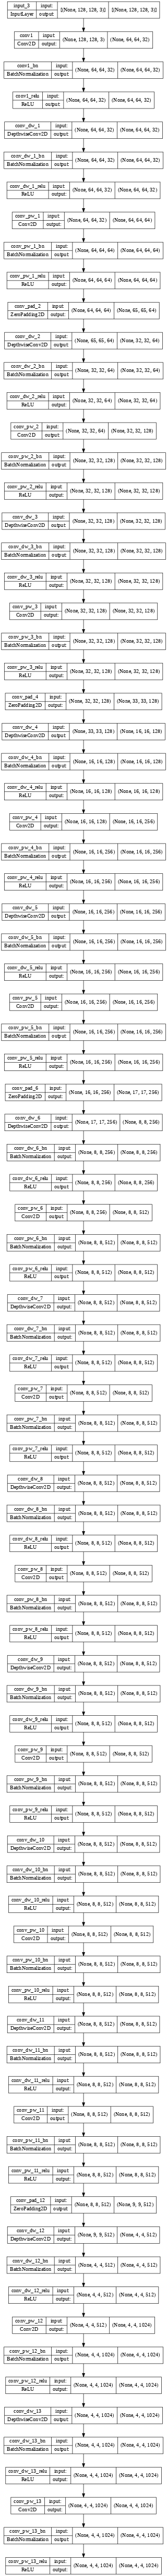

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(MobilNet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

In [23]:
#Now, let us use features from convolutional network for RF
feature_extractor=MobilNet_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

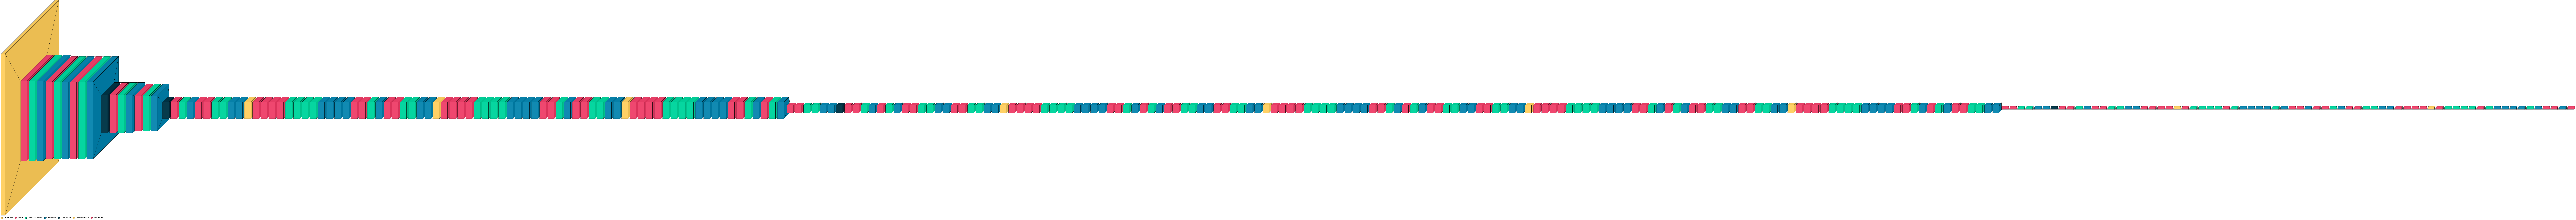

<Figure size 144x144 with 0 Axes>

In [24]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [25]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [27]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [28]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2972411186696901
MSE: 0.45483749055177625
RMSE: 0.67441640738625
R2 Square 0.3720894327538885
Accuracy 0.7809901738473167
__________________________________


In [29]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.78099


In [30]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.72      0.44      0.55       949
           1       0.79      0.74      0.76      1493
           2       0.77      0.93      0.84      2527
           3       0.97      0.79      0.87       323

    accuracy                           0.78      5292
   macro avg       0.81      0.73      0.76      5292
weighted avg       0.78      0.78      0.77      5292



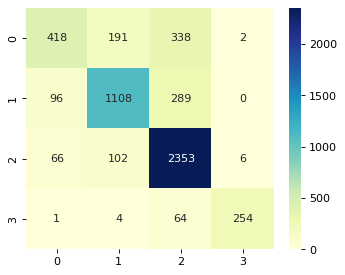

In [31]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [33]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [34]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.47430083144368856
MSE: 0.7392290249433107
RMSE: 0.8597842897746566
R2 Square -0.020517714610215343
Accuracy 0.6517384731670446
__________________________________


In [35]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738


In [36]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43       949
           1       0.63      0.62      0.62      1493
           2       0.75      0.75      0.75      2527
           3       0.67      0.68      0.68       323

    accuracy                           0.65      5292
   macro avg       0.62      0.62      0.62      5292
weighted avg       0.65      0.65      0.65      5292



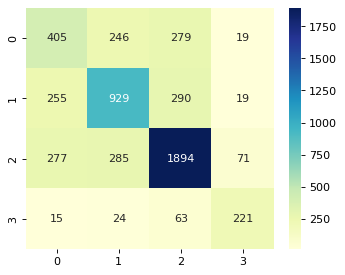

In [37]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [38]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [39]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [40]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2118291761148904
MSE: 0.3116024187452759
RMSE: 0.5582135959874821
R2 Square 0.5698277833864405
Accuracy 0.8380574452003023
__________________________________


In [41]:
results_df_2 = pd.DataFrame(data=[["Lojistik regresyon", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738
2,Lojistik regresyon,0.211829,0.311602,0.558214,0.569828,0.838057


In [42]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       949
           1       0.82      0.80      0.81      1493
           2       0.86      0.91      0.88      2527
           3       0.95      0.92      0.94       323

    accuracy                           0.84      5292
   macro avg       0.85      0.83      0.84      5292
weighted avg       0.84      0.84      0.84      5292



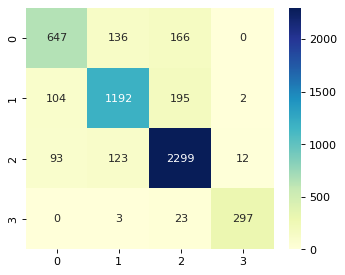

In [43]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [44]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [46]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [47]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.23639455782312926
MSE: 0.359599395313681
RMSE: 0.5996660698369394
R2 Square 0.5035671751269837
Accuracy 0.8248299319727891
__________________________________


In [48]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738
2,Lojistik regresyon,0.211829,0.311602,0.558214,0.569828,0.838057
3,LGBMClassifier,0.236395,0.359599,0.599666,0.503567,0.824830


In [49]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66       949
           1       0.81      0.81      0.81      1493
           2       0.83      0.93      0.88      2527
           3       0.95      0.86      0.90       323

    accuracy                           0.82      5292
   macro avg       0.84      0.79      0.81      5292
weighted avg       0.82      0.82      0.82      5292



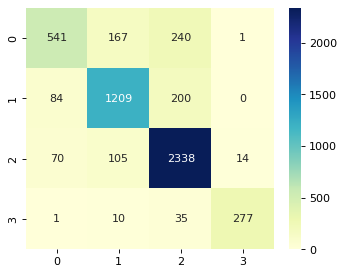

In [50]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [52]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [53]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.28325774754346184
MSE: 0.42724867724867727
RMSE: 0.653642621964539
R2 Square 0.41017623907625345
Accuracy 0.7881708238851096
__________________________________


In [54]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738
2,Lojistik regresyon,0.211829,0.311602,0.558214,0.569828,0.838057
3,LGBMClassifier,0.236395,0.359599,0.599666,0.503567,0.824830
4,RandomForestClassifier,0.283258,0.427249,0.653643,0.410176,0.788171


In [55]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.78      0.40      0.53       949
           1       0.76      0.79      0.77      1493
           2       0.79      0.93      0.86      2527
           3       0.96      0.77      0.86       323

    accuracy                           0.79      5292
   macro avg       0.82      0.72      0.75      5292
weighted avg       0.79      0.79      0.77      5292



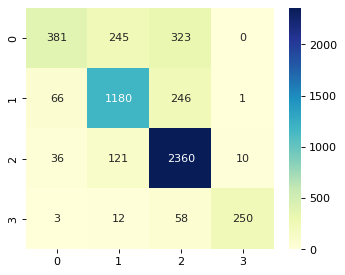

In [56]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [57]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [58]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [59]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4657974300831444
MSE: 0.7299697656840514
RMSE: 0.8543826810534325
R2 Square -0.007735156323942061
Accuracy 0.66005291005291
__________________________________


In [60]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738
2,Lojistik regresyon,0.211829,0.311602,0.558214,0.569828,0.838057
3,LGBMClassifier,0.236395,0.359599,0.599666,0.503567,0.824830
4,RandomForestClassifier,0.283258,0.427249,0.653643,0.410176,0.788171
5,GaussianNB,0.465797,0.729970,0.854383,-0.007735,0.660053


In [61]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.53      0.34      0.42       949
           1       0.76      0.55      0.64      1493
           2       0.68      0.83      0.75      2527
           3       0.48      0.76      0.59       323

    accuracy                           0.66      5292
   macro avg       0.61      0.62      0.60      5292
weighted avg       0.66      0.66      0.65      5292



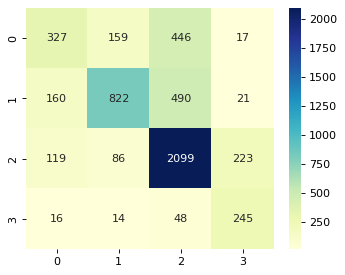

In [62]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [63]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [64]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [65]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.23450491307634164
MSE: 0.3554421768707483
RMSE: 0.5961897155023292
R2 Square 0.5093062829289839
Accuracy 0.825774754346183
__________________________________


In [66]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738
2,Lojistik regresyon,0.211829,0.311602,0.558214,0.569828,0.838057
3,LGBMClassifier,0.236395,0.359599,0.599666,0.503567,0.824830
4,RandomForestClassifier,0.283258,0.427249,0.653643,0.410176,0.788171
5,GaussianNB,0.465797,0.729970,0.854383,-0.007735,0.660053
6,SGDClassifier,0.234505,0.355442,0.596190,0.509306,0.825775


In [67]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       949
           1       0.85      0.75      0.80      1493
           2       0.85      0.90      0.87      2527
           3       0.95      0.92      0.93       323

    accuracy                           0.83      5292
   macro avg       0.84      0.82      0.83      5292
weighted avg       0.83      0.83      0.83      5292



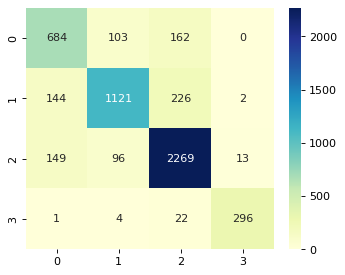

In [68]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [69]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [70]:
X_test_feature = MobilNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [71]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.23412698412698413
MSE: 0.3543083900226757
RMSE: 0.5952380952380952
R2 Square 0.5108714941477113
Accuracy 0.8252078609221466
__________________________________


In [72]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_MobilNet_model' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738
2,Lojistik regresyon,0.211829,0.311602,0.558214,0.569828,0.838057
3,LGBMClassifier,0.236395,0.359599,0.599666,0.503567,0.824830
4,RandomForestClassifier,0.283258,0.427249,0.653643,0.410176,0.788171
5,GaussianNB,0.465797,0.729970,0.854383,-0.007735,0.660053
6,SGDClassifier,0.234505,0.355442,0.596190,0.509306,0.825775
7,SVC,0.234127,0.354308,0.595238,0.510871,0.825208


In [73]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       949
           1       0.82      0.77      0.80      1493
           2       0.86      0.89      0.87      2527
           3       0.94      0.92      0.93       323

    accuracy                           0.83      5292
   macro avg       0.83      0.82      0.83      5292
weighted avg       0.82      0.83      0.82      5292



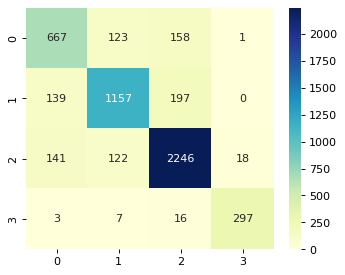

In [74]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [76]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [77]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_MobilNet_model"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_MobilNet_model"])
    sonuclar = sonuclar.append(sonuc)
    

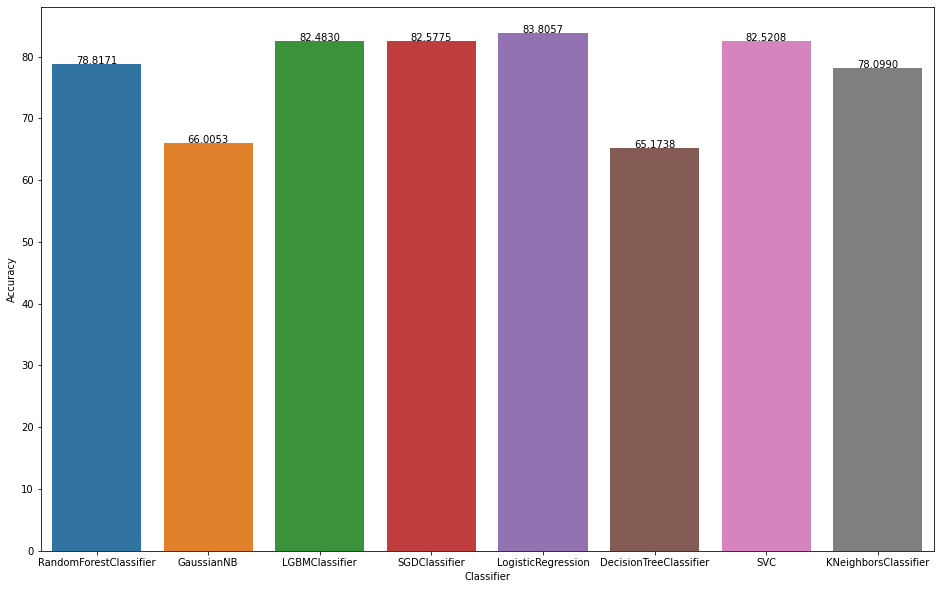

In [79]:
plt.figure(figsize=[16, 10])
axis = sns.barplot(x = 'Modeller', y = 'Accuracy_MobilNet_model', data = sonuclar)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
  height = p.get_height()
  axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 

In [81]:
best_acc=sonuclar.sort_values(by=['Accuracy_MobilNet_model'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_MobilNet_model
0,LogisticRegression,83.805745


In [82]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_MobilNet_model
0,KNeighborsClassifier,0.297241,0.454837,0.674416,0.372089,0.780990
1,DecisionTreeClassifier,0.474301,0.739229,0.859784,-0.020518,0.651738
2,Lojistik regresyon,0.211829,0.311602,0.558214,0.569828,0.838057
3,LGBMClassifier,0.236395,0.359599,0.599666,0.503567,0.824830
4,RandomForestClassifier,0.283258,0.427249,0.653643,0.410176,0.788171
5,GaussianNB,0.465797,0.729970,0.854383,-0.007735,0.660053
6,SGDClassifier,0.234505,0.355442,0.596190,0.509306,0.825775
7,SVC,0.234127,0.354308,0.595238,0.510871,0.825208


In [ ]:
from google.colab import files

results_df.to_csv('output_vgg19.csv', encoding = 'utf-8-sig') 
files.download('output_vgg19.csv')